# Statistical Inference on Quantitative Characteristics of Cammeo & Osmancik Rice
**Authors:** Nour Abdelfattah, Muhammad Shahbaz Murtaza, Sky Yun and Emiliano Hernández Castillo

**Group:** 47

## 1. Introduction
The genetic varieties of rice are usually separated by specific features such as texture, shape and color. These sets of characteristics have been widely researched to be able to differentiate rice species from one another (Koklu, 2021). Most research attempts to classify different species of rice by taking a sample of rice grains and generating grain images, using a set of features and performing classification processes to predict rice species. This concept is necessary for agricultural practices and due to an increase in the world’s population and harmful environmental phenomenons such as global warming, it is important to be able to identify and use healthy, high quality seeds (Tugrul, 2022).



To analyze the features of rice species, our primary inferential question is: **Do the major axis length and perimeter in Cammeo rice differ from the major axis length and perimeter of Osmanick rice?**

This data set, `Rice_Cammeo_Osmancik`,  was originally taken from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik). The dataset contains a total 3810 observations of two species of rice, Cammeo and Osmancik, and their corresponding morphological characteristics. The variables of interest are described below:

- `major_axis_length`: Describes the longest line that can be drawn on the grain of rice.
- `perimeter`: Calculates the circumference on the grain of rice.

## 2. Preliminary Analysis

### 2.1 Loading Library Dependencies

In [2]:
# Run this before continuing
install.packages("ggcorrplot")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
# run this before continuing
library(tidyverse)   #Allows to transform and present data
library(ggplot2)     #Allows to present data vectors accordingly
library(gridExtra)   #Allows to organize presented data graphs
library(grid)        #Allows to organize presented data graphs
library(ggcorrplot)  #Allows to render correlation plot w/ according vectors
library(infer)
library(broom)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




### 2.2 Reading and Wrangling Rice Data Set into R

In [5]:
#Reading original Rice data set from Github repository to R
url<- "https://raw.githubusercontent.com/yun-sky/stat-201-project/main/Rice_Cammeo_Osmancik.arff"
rice_data <- read.csv(url, header=FALSE, comment.char = "@", skip = 4) |>
                      type.convert(as.is= TRUE) #Converting character data type into double data type                  

#Assigning correct column names
colnames(rice_data) <- c("area", "perimeter", "major_axis_length", "minor_axis_length", "eccentricity", 
                            "convex_area", "extent", "class")


### 2.3 Exploratory Data Analysis

We want to observe the correlation of class between variables. We will choose our variables accordingly by calculating the **point-biserial correlation** between the class of rice and all the continuous variables.

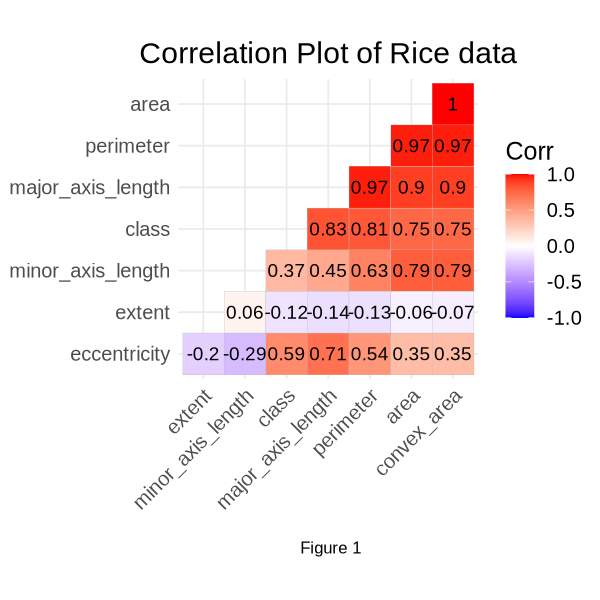

In [6]:
options(repr.plot.width = 5, repr.plot.height = 5)

#Converting Data set into binary class variable and correct vectors for Corr plot
binary_data <- rice_data |>
     mutate(class = ifelse(class == "Cammeo",1,0)) |>
     cor(use="complete.obs") 

#Plotting Corr plot
ggcorrplot(binary_data, 
           hc.order = TRUE, 
           type = "lower",
           lab = TRUE) +

labs(title = "Correlation Plot of Rice data",
     caption = "\n Figure 1") +

theme(text = element_text(size = 15),
      plot.title = element_text(hjust = 0.5),
      plot.caption = element_text(size = 10, hjust = 0.5))

*Figure 1.0* indicates that the `major_axis_length` and the `perimeter` have the highest correlation with `class`. Thus we will analyze these variables to determine if  there are differences between properties of Cammeo and Osmancik Rice.

In [7]:
#Given Correlation plot we can select our variables from the data set
cleaned_rice_data <- rice_data|>
                     select(perimeter, major_axis_length, class) 

head(cleaned_rice_data) 

,perimeter,major_axis_length,class
,<dbl>,<dbl>,<chr>
1,525.579,229.7499,Cammeo
2,494.311,206.0201,Cammeo
3,501.122,214.1068,Cammeo
4,458.343,193.3374,Cammeo
5,507.167,211.7434,Cammeo
6,477.016,200.0531,Cammeo


 To further analyze this correlation, we will plot the side-by-side boxplots for each of our variables of interest. 

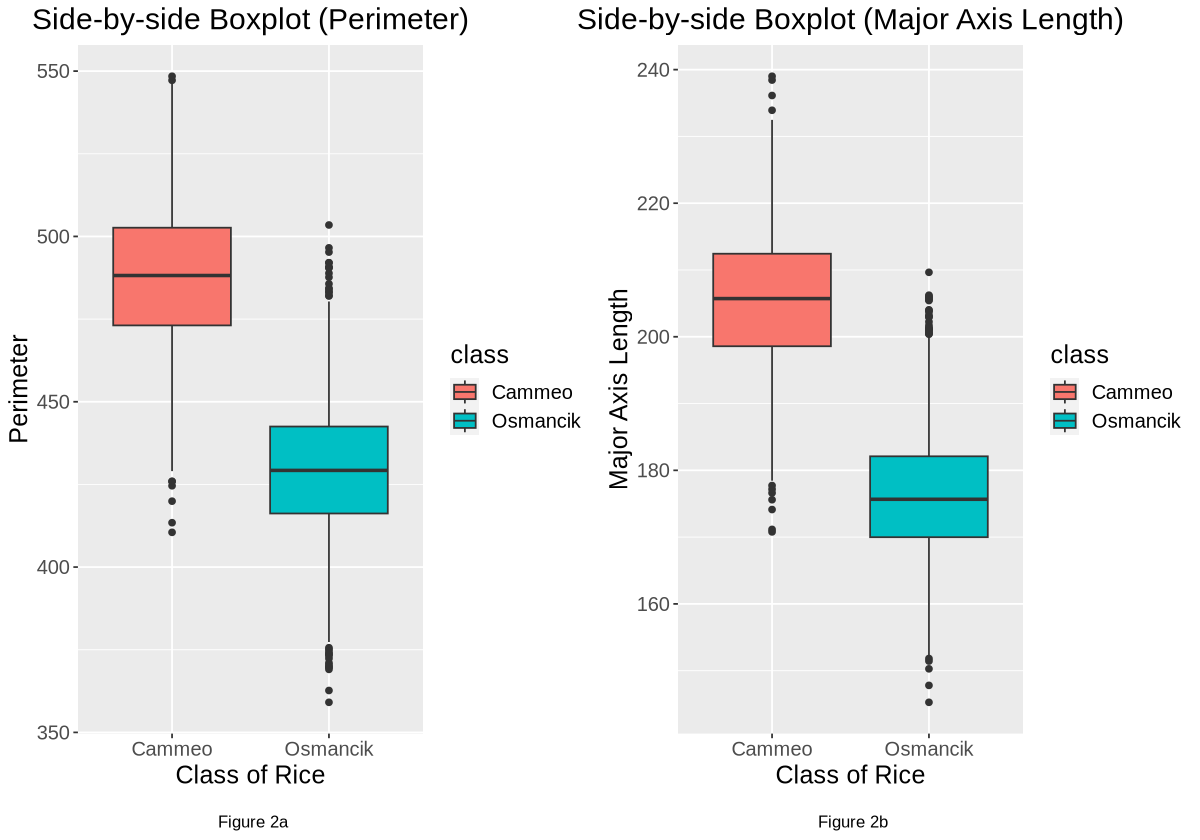

In [8]:
options(repr.plot.width = 10, repr.plot.height = 7)

#Plotting major_axis_length vs class box plot
mal_plot <- ggplot(cleaned_rice_data, aes(x = class, y = major_axis_length)) +  
    geom_boxplot(aes(fill = class)) +
    xlab("Class of Rice") +
    ylab("Major Axis Length") +
    labs(title = "Side-by-side Boxplot (Major Axis Length)",
         caption = "\n Figure 2b") +
    theme(text = element_text(size = 15),
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(size = 10, hjust = 0.5))



#Plotting perimeter vs class boxplot
peri_plot <- ggplot(cleaned_rice_data, aes(x = class, y = perimeter)) +
    geom_boxplot(aes(fill = class)) +
    xlab("Class of Rice") +
    ylab("Perimeter") +
    labs(title = "Side-by-side Boxplot (Perimeter)",
         caption = "\n Figure 2a") +
    theme(text = element_text(size = 15),
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(size = 10, hjust = 0.5))



#Arranges the plots in a neater format
grid.arrange(peri_plot, mal_plot, ncol = 2)

From our boxplots in *Figure 2a & 2b*, it can be inferred that the mean Cammeo rice has a larger perimeter and major axis length than Osmancik. However, to explore this quantitatively, we will do hypothesis testing. But first, we will calculate the data parameter estimates from our sample.

### 2.4 Data Parameter Estimates

In [9]:
# Calculating the mean and standard deviation for each selected class
summary_rice <- cleaned_rice_data |>
    group_by(class) |>
    summarize(mean_perimeter = mean(perimeter), mean_mal = mean(major_axis_length), 
              sd_perimeter = sd(perimeter), sd_mal = sd(major_axis_length))

summary_rice

class,mean_perimeter,mean_mal,sd_perimeter,sd_mal
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Cammeo,487.4389,205.4786,22.18152,10.333854
Osmancik,429.4155,176.2878,20.15439,9.362405


In [10]:
# Calculating the parameters of interest: difference in means and difference in standard deivation for the perimeter
# major axis length
rice_estimates <- summary_rice %>%
    pivot_wider(names_from = class, values_from = c(mean_perimeter, mean_mal, sd_perimeter, sd_mal)) |>
    mutate(mean_diff_perimeter = mean_perimeter_Cammeo - mean_perimeter_Osmancik,
           mean_diff_mal       = mean_mal_Cammeo - mean_mal_Osmancik,
           sd_diff_perimeter   = sd_perimeter_Cammeo - sd_perimeter_Osmancik,
           sd_diff_mal         = sd_mal_Cammeo - sd_mal_Osmancik) |>
    select(mean_diff_perimeter, mean_diff_mal, sd_diff_perimeter, sd_diff_mal)

rice_estimates

mean_diff_perimeter,mean_diff_mal,sd_diff_perimeter,sd_diff_mal
<dbl>,<dbl>,<dbl>,<dbl>
58.02344,29.19083,2.027124,0.9714491


## 3. Methods: Plan


As our dataset was collected from a reputable source and the analysis done was peer-reviewed, we feel confident in our initial findings. Although our visualizations allow us to draw inferences about the relationships between our predictors and response, they do not prove anything. To do so, we hypothesize below and later test those claims:

**Difference in means**
- $H_0: \mu_1 - \mu_2 = 0$
- $H_A: \mu_1 - \mu_2  > 0$

Where $\mu_1$ and $\mu_2$ are the mean of the variables of interest of Cammeo and Osmanik rice respectively.

The above hypothesis tests will be performed on both `major_axis_length` and `perimeter`. We will conduct bootstrapping and CLT to make conclusions about our hypotheses. From that, 95% confidence intervals will be drawn for the difference in means, and the analysis will conclude with a comparison of both methods.

We can expect to reject our null for all of our hypothesis tests (refer to figure 2a, 2b). Due to the rejection of the null, we can also expect our 95% confidence intervals for difference in means to not contain 0. 

These conclusions can mean that classification between Cammeo and Osmancik would be much easier given the two predictors we are interested in. These findings could be important for business in the agricultural sector. It is also within our interest to explore our variables, `perimeter` and `major_axis_length` further to see which farming techniques could optimize the rice growth and in turn increase profits.

## 4. Methods: Hypothesis Testing and Confidence Intervals
For all of our hypothesis tests, we will use a significance level of $\alpha = 0.05$. We will use the bootstrapping and the $t$-test method for both of our variables in order to test our hypotheses. We decided to use the $t$-test over the $z$-test since we do not know the true standard deviations of either of our populations. Aside from that, we will be finding the 95% confidence intervals for each method and variable. 

### 4.1 Difference in Means for `perimeter`
We will test the following hypotheses wher $\mu_1$ is the **perimeter** mean of Cammeo rice while $\mu_2$ is the **perimeter** mean of Osmancik rice. 

> $H_0: \mu_1 = \mu_2 \equiv \mu_1 - \mu_2 = 0$\
> $H_A: \mu_1 > \mu_2 \equiv \mu_1 - \mu_2 > 0$

In [74]:
# Preliminary Calculations in order to aid our analysis
# Separting the data by class 
cammeo_sample <- filter(cleaned_rice_data, class == "Cammeo")
osmancik_sample <- filter(cleaned_rice_data, class == "Osmancik")

# Counting the number of observations in each sample
n_cammeo <- nrow(cammeo_sample) 
n_osmancik <- nrow(osmancik_sample)

#### 4.1.1 Bootstrapping Method: Hypothesis Testing 

In [75]:
# Creating the test_statistic
se_mean_perimeter <- sqrt(var(cammeo_sample$perimeter)/n_cammeo + var(osmancik_sample$perimeter)/n_osmancik) # Standard Error
diff_mean_perimeter <- rice_estimates$mean_diff_perimeter[1] # Difference in perimeter means between Cammeo and Osmanik rice

test_stat_mean_perimeter <- diff_mean_perimeter / se_mean_perimeter
test_stat_mean_perimeter

[1] 83.04477

We will now use the infer package to generate the null-distribution and calculate the $p$-value for our test-statistic. 

In [76]:
# hypothesis testing using bootstrapping
set.seed(2023)

# Generate the bootstrap distribution for difference in  means
bootstrap_dist_perimeter <- cleaned_rice_data %>%
    specify(formula = perimeter ~ class) %>%
    hypothesize(null = "independence") %>%
    generate(type = "permute", reps = 1000) %>%
    calculate(stat = "diff in means", order = c("Cammeo", "Osmancik"))

In [66]:
# Calculate the p-value of the test statistic
p_val_bootstrap_perimeter <- get_p_value(bootstrap_dist_perimeter, obs_stat = test_stat_mean_perimeter, direction = "right")
p_val_bootstrap_perimeter$p_value[1]

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


[1] 0

##### Results
Observing the results above, we have obtained a $p$-value that is very close to zero, so we reject the null-hypothesis with a significance level of $\alpha = 0.05$. This suggests that the true Cammeo perimeter mean is greater than the Osmancik perimeter mean. We can visualize the null-distribution with the test statistic to see where the test statistic lies on the distribution. 

Warning message in min(diff(unique_loc)):
“no non-missing arguments to min; returning Inf”


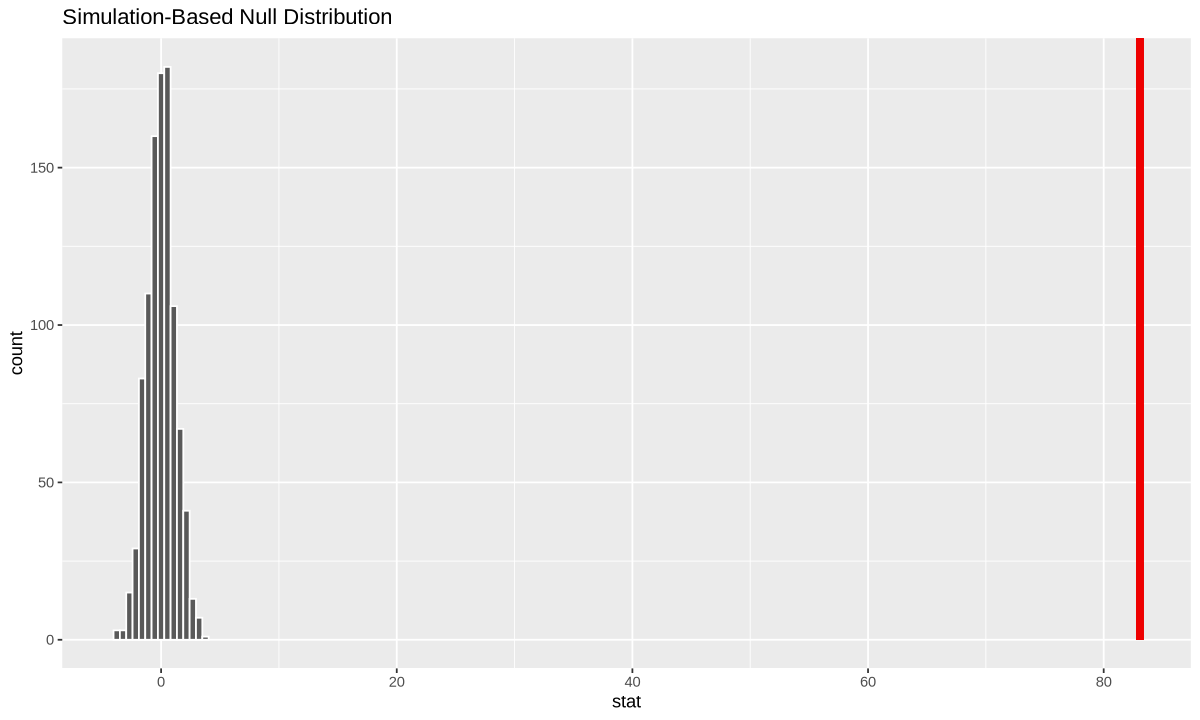

In [71]:
# Visualize Bootstrap Distribution
bootstrap_perimeter_hist <- visualize(bootstrap_dist_perimeter) +
    shade_p_value(test_stat_mean_perimeter, direction = "right")
bootstrap_perimeter_hist
# RESULTS: we reject the null hypothesis, which suggests that there is a statistically significant
#          difference between the null hypothesis that

#### 4.1.2 Bootstrapping Method: Confidence Intervals

In [100]:
# Generate bootstrap distribution for difference in perimeter means
bootstrap_perimeter_dist <- cleaned_rice_data %>%
    specify(formula = perimeter ~ class) %>%
    generate(type = "bootstrap", reps = 1000) %>%
    calculate(stat = "diff in means", order = c("Cammeo", "Osmancik"))

# Calculate the 95% confidence interval for the difference in perimeter means
bootstrap_perimeter_ci <- get_ci(bootstrap_perimeter_dist, level = 0.95)
bootstrap_perimeter_ci

lower_ci,upper_ci
<dbl>,<dbl>
56.60339,59.3525


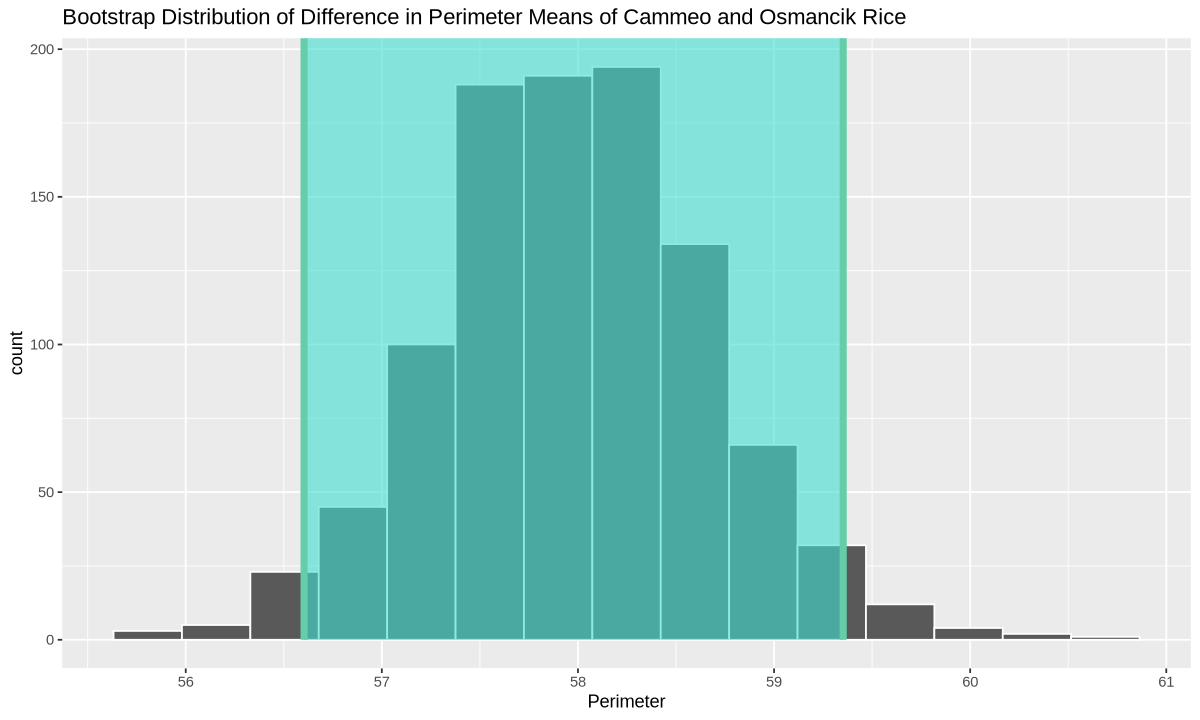

In [101]:
# Visualize the bootstrap distribution and confidence interval
bootstrap_perimeter_dist_ci <- visualize(bootstrap_perimeter_dist) +
    shade_ci(bootstrap_perimeter_ci) +
    labs(x = "Perimeter", 
         title = "Bootstrap Distribution of Difference in Perimeter Means of Cammeo and Osmancik Rice")

bootstrap_perimeter_dist_ci

#### 4.1.3 t-distribution Method: Hypothesis Testing Using `t.test()`
##### Preliminary Calculations and Observations
Both of our populations must be normally distributed in order to apply the $t$-test. Since the population distribution is unknown in our case, we will use the sample distribution in order to estimate our population distribution. The sample sizes are large enough so we should obtain relatively accurate estimates of both population distributions. 

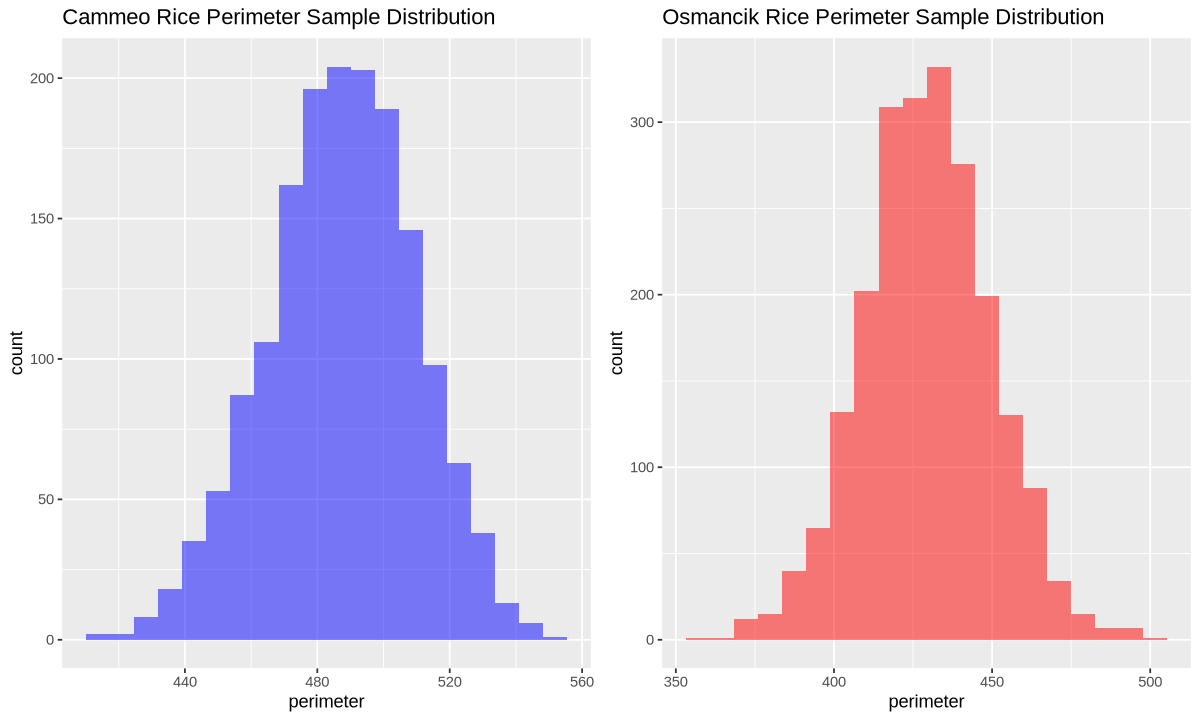

In [62]:
options(repr.plot.width = 10, repr.plot.height = 6)

# Sample distribution of Cammeo perimeter 
cammeo_dist <- ggplot(cammeo_sample, aes(x = perimeter)) + 
    geom_histogram(bins = 20, fill = "blue", alpha = 0.5) +
    labs(title = "Cammeo Rice Perimeter Sample Distribution")

# Sample distribution of Osmancik perimeter 
osmancik_dist <- ggplot(osmancik_sample, aes(x = perimeter)) +
    geom_histogram(bins = 20, fill = "red", alpha = 0.5) +
    labs(title = "Osmancik Rice Perimeter Sample Distribution")

# Arrange the histograms side by side
grid.arrange(cammeo_dist, osmancik_dist, ncol = 2)

Since both of the samples are nearly normal and have sizes larger than 30, we may proceed with using the $t$-test.

In [79]:
# Conducting t-test using t.test() function
t_results_mean_perimeter <- tidy(t.test(mu = 0,
                                       x = cammeo_sample$perimeter,
                                       y = osmancik_sample$perimeter, 
                                       alternative = "greater",
                                       conf.level = 0.99)) %>%
                            rename(diff_in_mean_perimeter = estimate,
                                   cammeo_mean = estimate1,
                                   osmancik_mean = estimate2)
t_results_mean_perimeter

diff_in_mean_perimeter,cammeo_mean,osmancik_mean,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
58.02344,487.4389,429.4155,83.04477,0,3316.182,56.39723,Inf,Welch Two Sample t-test,greater


In [80]:
# Pull the p-value from the table
p_val_t_perimeter <- t_results_mean_perimeter$p.value[1]
p_val_t_perimeter

[1] 0

##### Results
Similar to our bootstrapping method, we have obtained a $p$-value that is extremely close to zero. Thus, we reject the null-hypothesis in favour for the alternative under a significance level of $0.05$, suggesting that the perimeter mean of Cammeo rice is greater than that of Osmancik. We will visualize the distribution in order to gauge where the test-statistic lies. 

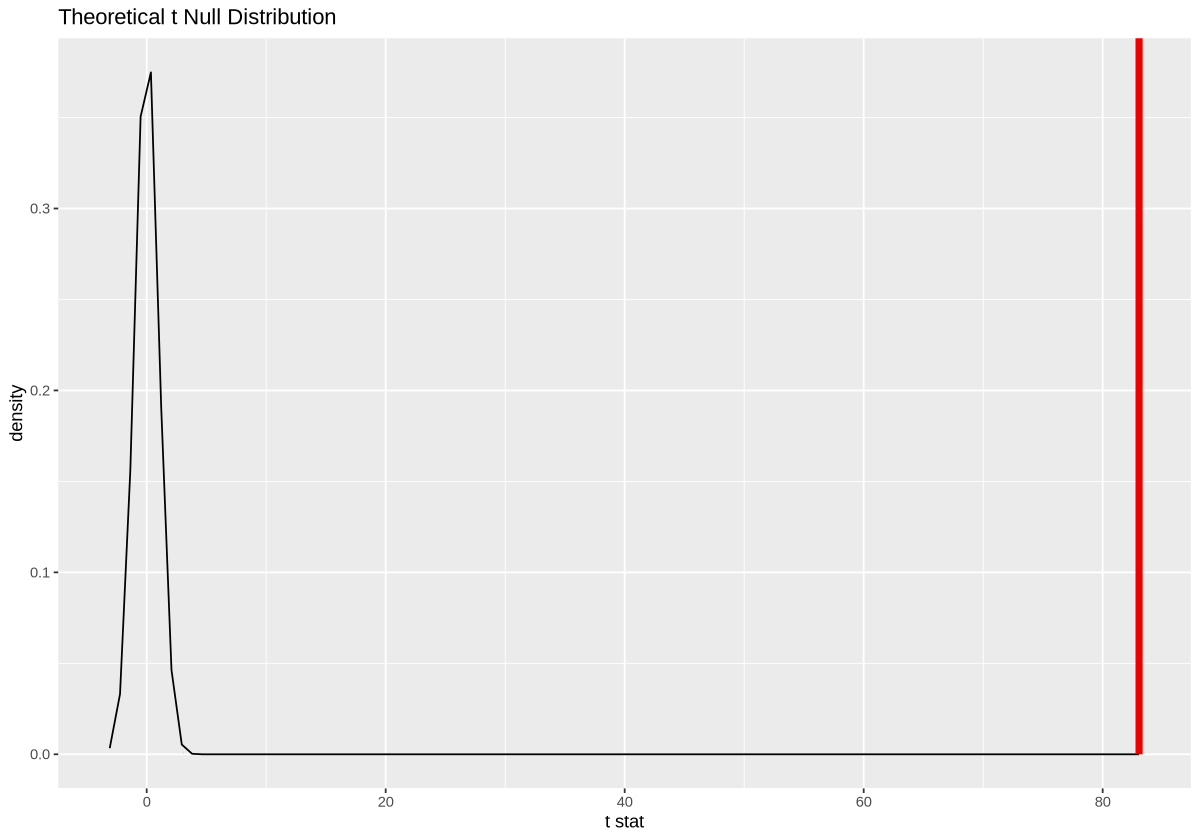

In [15]:
t_null_dist <- cleaned_rice_data %>%
    specify(formula = perimeter ~ class) %>%
    assume(distribution = "t")
visualize(t_null_dist) + shade_p_value(test_stat_mean_perimeter, direction = "right")

#### 4.1.4 $t$-distribution Method: Confidence Intervals

### 4.2 Hypothesis Testing: Difference in Means for `major_axis_length`

In [16]:
# Using infer workflow to generate study H_0 of diff in means (major_axis_length) for both types of rice

bootstrap_dist_mal <- cleaned_rice_data %>%
    specify(formula = major_axis_length ~ class) %>%
    hypothesize(null = "independence") %>%
    generate(type = "permute", reps = 1500) %>%
    calculate(stat = "diff in means", order = c("Cammeo", "Osmancik"))

#### Calculating Test Statistic 

In [18]:
#Calculating corresponding test statistic

test_stat <- ((summary_rice$mean_mal[1] - summary_rice$mean_mal[2])/sqrt(((summary_rice$sd_mal[1])^2/ n_cammeo) + ((summary_rice$sd_mal[2])^2/ n_osmancik)))

#### Visualizing Bootstrap Results

Warning message in min(diff(unique_loc)):
“no non-missing arguments to min; returning Inf”


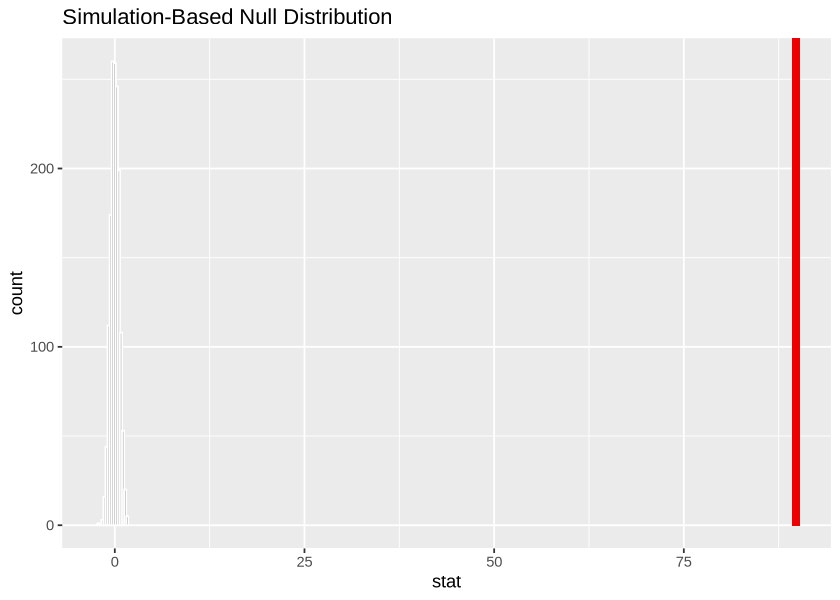

In [19]:
options(repr.plot.width = 7, repr.plot.height = 5)

#Rendering Bootstrap distribution with calculated test statistic

bootstrap_mal <- visualize(bootstrap_dist_mal) +
    shade_p_value(test_stat, direction = "right")

bootstrap_mal

#### Visualizing P-value & Overall Statistics through `t.test()`

In [29]:
# Obtaining p-value, among others to reiterate rejection of H_0

t_results_mean_mal <- tidy(t.test(mu = 0, x = cammeo_sample$major_axis_length, y = osmancik_sample$major_axis_length, 
                                       alternative = "greater",
                                       conf.level = 0.95)) %>%

                      rename(diff_mean_mal = estimate,
                             cammeo_mean = estimate1,
                             osmancik_mean = estimate2)

t_results_mean_mal

diff_mean_mal,cammeo_mean,osmancik_mean,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
29.19083,205.4786,176.2878,89.77632,0,3310.051,28.65586,Inf,Welch Two Sample t-test,greater


In [30]:
options(repr.plot.width = 7, repr.plot.height = 5)

#Visualizing t-distribution according to null hypothesis

t_null_dist <- cleaned_rice_data %>%
        specify(formula = major_axis_length ~ class) %>%
        assume(distribution = "t")
        visualize(t_null_dist) + shade_p_value(test_stat, direction = "right")

ERROR: Error in vapply(list(...), ggplot2::is.ggplot, logical(1)): object 'test_stat' not found


### 4.3 Hypothesis testing using CLT for major axis length variable

Figure 2b above shows that Cammeo rice have a longer major axis comapred to Osmancik rice but our dataset only represents a sample of the rice species and not all Cammeo and Osmancik rice therefore, it is necessary to conduct hypothesis testing. The shape of our underlying population distribution is unknown but our dataset is quite large so we can say that we are using a large sample size (n) for our hypothesis testing and can therefore rely on CLT. Conducting a t-test using a large dataset means that it will asymptotically aproach a normal distribution due to CLT. We are also assuming that we have 2 independent random samples, one from each population of rice species, which aligns with the assumptions and conditions of CLT. The hypotheses being tested are: 

- $H_0: \mu_1 - \mu_2 = 0$
- $H_A: \mu_1 - \mu_2  > 0$

where $\mu_1$ = Mean major axis length of Cammeo rice and $\mu_2$ = Mean major axis length of Osmanick rice 

We will be using a 0.05 signficance level for our hypothesis testing.

In [ ]:
cammeo <- cleaned_rice_data %>%
filter(class == 'Cammeo')

osmancik <- cleaned_rice_data %>%
filter(class == 'Osmancik')

#use t test to obtain test statistic and p value
t_test <- broom::tidy(
    t.test(mu = 0, 
           x = cammeo$major_axis_length, 
           y = osmancik$major_axis_length,
          alternative = 'greater'))
t_test

Since our test statistic is quite large with a value of 89.8, our p value is very small (approximately 0) which indicates that we should reject our null hypothesis at the 0.05 significance level. The results show that there is a sigficant difference between the mean major axis length of Cammeo rice and the mean major axis length of Osmancik rice, with Cammeo rice having a greater major axis length. 

In [ ]:
#filtered rice type cammeo and pulled perimeter
cammeo_p <- cleaned_rice_data %>%
filter(class == 'Cammeo') |>
pull(perimeter)

#filtered rice type osmancik and pulled perimeter
osmancik_p <- cleaned_rice_data %>%
filter(class == 'Osmancik') |>
pull(perimeter)

#two sample t-test since it is a difference in means of two independent samples 
t_test_perimeter <- broom::tidy(t.test(x = cammeo_p,
       y = osmancik_p,
       alternative = "greater"))
t_test_perimeter


Similarly, as we had for the major axis length, the difference in perimeter has a very small, almost negligible p-value which suggests that we should reject the null under significance level of 5% and conclude that the mean perimeter is indeed greater for Cammeo than Osmancik. To compare findings from this test under CLT with our bootstrapped test, we must find the corresponding 95% confidence interval using CLT. 

In [ ]:
# 95% confidence interval for difference in mean perimeter between Cammeo and Osmancik using CLT
perimeter_diff_means_ci <- 
    tibble(
        lower_perimeter_ci = mean(cammeo) - mean(osmancik) - qnorm(1-(0.05/2)) * sqrt(var(cammeo)/length(cammeo) + var(osmancik)/length(osmancik)),
        upper_perimeter_ci = mean(cammeo) - mean(osmancik) + qnorm(1-(0.05/2)) * sqrt(var(cammeo)/length(cammeo) + var(osmancik)/length(osmancik))
    )

perimeter_diff_means_ci


## References
- Rice (Cammeo and Osmancik). (2019). UCI Machine Learning Repository. https://doi.org/10.24432/C5MW4Z.

- [Koklu, M., Cinar, I., & Taspinar, Y. S. (2021). Classification of rice varieties with deep learning methods. Computers and Electronics in Agriculture, 187, 106285. https://doi.org/10.1016/j.compag.2021.106285](https://www.sciencedirect.com/science/article/pii/S0168169921003021)

- [Tuğrul, B. (2022). Classification of five different rice seeds grown in Turkey with deep learning methods . Communications Faculty of Sciences University of Ankara Series A2-A3 Physical Sciences and Engineering , 64 (1) , 40-50 . DOI: 10.33769/aupse.1107590](https://dergipark.org.tr/en/pub/aupse/issue/68241/1107590)